## Lunar lander TD-0 with the Kalman filter
### Using SARSA

In [1]:
import gymnasium as gym
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from numba import njit

In [2]:
np.set_printoptions(linewidth=200)
%config InlineBackend.figure_format = "retina"
sns.set_palette("colorblind")

In [3]:
env = gym.make("LunarLander-v3")

## Single run

## The action-value function

$$
    q(s, a, {\bf w}) = {\bf w}_a^\intercal\phi(s)
$$

In [4]:
actions = np.arange(4)
n_actions = 4

In [5]:
normalization_constants = np.array([
    1.0 / 3.0,     # x-position
    1.0 / 1.5,     # y-position
    1.0 / 4.0,     # x-velocity
    1.0 / 4.0,     # y-velocity
    1.0 / 6.28,    # angle (theta)
    1.0 / 10.0,    # angular velocity
    1.0,           # left leg contact
    1.0            # right leg contact
])

### Random Fourier Features as feature transformation

In [487]:
dim_state = len(normalization_constants) - 2
# number of random fourier features
n_rff = 5
# n_rff = dim_state // 2

omega_terms = np.random.randn(n_rff, dim_state)
norm_term = np.sqrt(2 / len(normalization_constants))


@njit
def phi(s):
    normalization_constants = np.array([
        1.0 / 3.0,     # x-position
        1.0 / 1.5,     # y-position
        1.0 / 4.0,     # x-velocity
        1.0 / 4.0,     # y-velocity
        1.0 / 6.28,    # angle (theta)
        1.0 / 10.0,    # angular velocity
        1.0,           # left leg contact
        1.0            # right leg contact
    ])

    s = s * normalization_constants

    s_inner = np.array([
        s[-1] * s[-2], # contact
        s[0] * s[1], # x/y position
        s[2] * s[3], # x/y velocity,
        s[4] * s[5], # angle and angular velocity
    ])
    
    sprime = np.concatenate((
        np.ones(1),
        s, s ** 2,
        # np.sin(2 * np.pi * s[:-2]),
        # np.cos(2 * np.pi * s[:-2]),
        np.sin(4 * np.pi * s),
        np.cos(4 * np.pi * s),
        s_inner,
    ))
    return sprime


@njit
def action_value(W, s, a):
    """
    Q(W, s, a)
    """
    w = W[a]
    return w @ phi(s)


def grad_action_value(W, s, a):
    return phi(s)


def eval_action_value(W, s, actions):
    q_a = np.array([action_value(W, s, ai) for ai in actions])
    return q_a


def choose_max_action(action_value_est):
    vmax = action_value_est.max()
    if np.sum(vmax == action_value_est) == 1:
        return np.argmax(action_value_est)
    else: # break ties
        actions = np.arange(len(action_value_est))
        av_sub = actions[action_value_est == vmax]
        return np.random.choice(av_sub)


def eps_greedy_choice(W, s, eps):
    u = np.random.uniform()
    if u < eps:
        a = np.random.choice(4)
    else:
        action_value_estimates = eval_action_value(W, s, actions)
        a = choose_max_action(action_value_estimates)
    return a



@njit
def loss(W, s, a, r, s_next, a_next, gamma):
    """
    Innovation process (the one-step-ahead error)
    """
    # SARSA
    delta = r + gamma * action_value(W, s_next, a_next) - action_value(W, s, a)
    
    # Q-learning
    # delta = r + gamma * max([action_value(W, s_next, a) for a in actions]) - action_value(W, s, a)
    
    return delta


@njit
def ktd_gain(Sigma_a, s, a, s_next, a_next, gamma, nu):
    # Full gradient
    # St = phi(s) @ Sigma_a @ phi(s).T + gamma ** 2 * phi(s_next) @ Sigma_a @ phi(s_next).T + nu
    # Kt = Sigma_a @ (phi(s) - gamma * phi(s_next))[:, None] / St

    # Semi-gradient
    St = phi(s) @ Sigma_a @ phi(s).T + nu
    Kt = Sigma_a @ phi(s)[:, None] / St

    # Leandro's breakthrough idea :(
    # St = phi(s_next) @ Sigma_a @ phi(s_next).T + nu
    # Kt = -Sigma_a @ phi(s_next)[:, None] / St
    return Kt


@njit
def update_ktd(Mu, Sigma, s, a, r, s_next, a_next, gamma, nu, q):
    """
    mu: (a x M)-dimensional array
        collection of parameter estimates
    Sigma: (a x M x M)-dimensional array
        collection of error variance covariance estimates.
        Sigma[a] corresponds to an M-dimensional positive definite matrix
    s: float
        current state
    a: int
        previous action
    r: float
        reward
    s_next: float
        transitioned state
    a_next: int
        next chosen action
    gamma: (0,1)
        discount rate
    nu: float
        observation (modelling) variance
    q: float
        dynamics (parameters) variance
    """
    Mu = np.copy(Mu)
    Sigma = np.copy(Sigma)
    I = np.eye(len(Mu[a]))

    td_err = loss(Mu, s, a, r, s_next, a_next, gamma)

    # Predict mean and covariance
    mu_a = Mu[a]
    Sigma_a = Sigma[a] + I * q

    # Kalman gain
    Kt = ktd_gain(Sigma_a, s, a, s_next, a_next, gamma, nu)

    # Update mean
    # import pdb; pdb.set_trace()
    mu_a = mu_a + Kt @ np.array((td_err,))
    # Update covariance: Joseph form
    correction = I - Kt @ phi(s)[None, :]
    Sigma_a = correction @ Sigma_a @ correction.T + Kt @ Kt.T * nu

    Mu[a] = mu_a
    Sigma[a] = Sigma_a

    return Mu, Sigma

## Dynamic filtering
Setting $Q_t = 10^{-4}$

In [607]:
n_steps = 100_000
eps = 1e-4
gamma = 0.999
Rt = np.eye(1) * 0.8

all_rewards = np.zeros(n_steps)
env = gym.make("LunarLander-v3")
observation, info = env.reset(seed=314)
final_rewards = []

# checkpoint_episodes = [1, 250, 500, 750, 1000, 1250, 1500]
checkpoint_episodes = [1, 100, 200, 300, 400]
checkpoint_weights = []

dim_phi = len(phi(observation))

np.random.seed(314)
M = np.random.randn(n_actions, dim_phi)
# M = M.astype("float32")
# M = np.zeros((n_actions, dim_phi))

sigma_init = 10.0 # 1.0
Sigma = np.einsum("a,ij->aij", np.ones(n_actions), np.eye(dim_phi)) * sigma_init

n_episodes = 0
action = 0
episode_reward = 0.0

ewm_rewards = 0.0
alpha = 2 / (100 + 1) # alpha in terms of span of 50

n_static = 650

for t in (pbar := tqdm(range(n_steps))):
    observation_next, reward, terminated, truncated, info = env.step(action)
    
    action_next = eps_greedy_choice(M, observation_next, eps)

    reset = terminated or truncated
    gamma_step = 0.0 if reset else gamma # Set gamma=0.0 if end of episode

    qt = 1e-5
    if len(final_rewards) >= n_static:
        qt = 0.0

    
    M, Sigma = update_ktd(
        M, Sigma, observation, action, reward, observation_next, action_next, gamma_step, Rt, qt
    )
    
    if reset:
        final_rewards.append(episode_reward)

        ewm_rewards = ewm_rewards * (1 - alpha) + episode_reward * alpha
        if (n_episodes := len(final_rewards)) % 100 == 0:
            pbar.set_description(f"{n_episodes:04} —> {ewm_rewards:0.2f}")
        
        observation, info = env.reset()
        action = eps_greedy_choice(M, observation, eps)
        episode_reward = 0.0

        if n_episodes in checkpoint_episodes:
            checkpoint_weights.append(M)
        
        n_episodes += 1
    else:
        episode_reward += reward
        observation = observation_next
        action = action_next
        
    all_rewards[t] = reward

# attach last 
checkpoint_weights.append(M)
checkpoint_episodes.append(n_episodes)

checkpoint_weights = np.stack(checkpoint_weights)
final_rewards = pd.Series(final_rewards)
print(f"\n{all_rewards.sum()}")
env.close()

0400 —> -48.74: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:06<00:00, 15268.63it/s]


-72888.19129653941


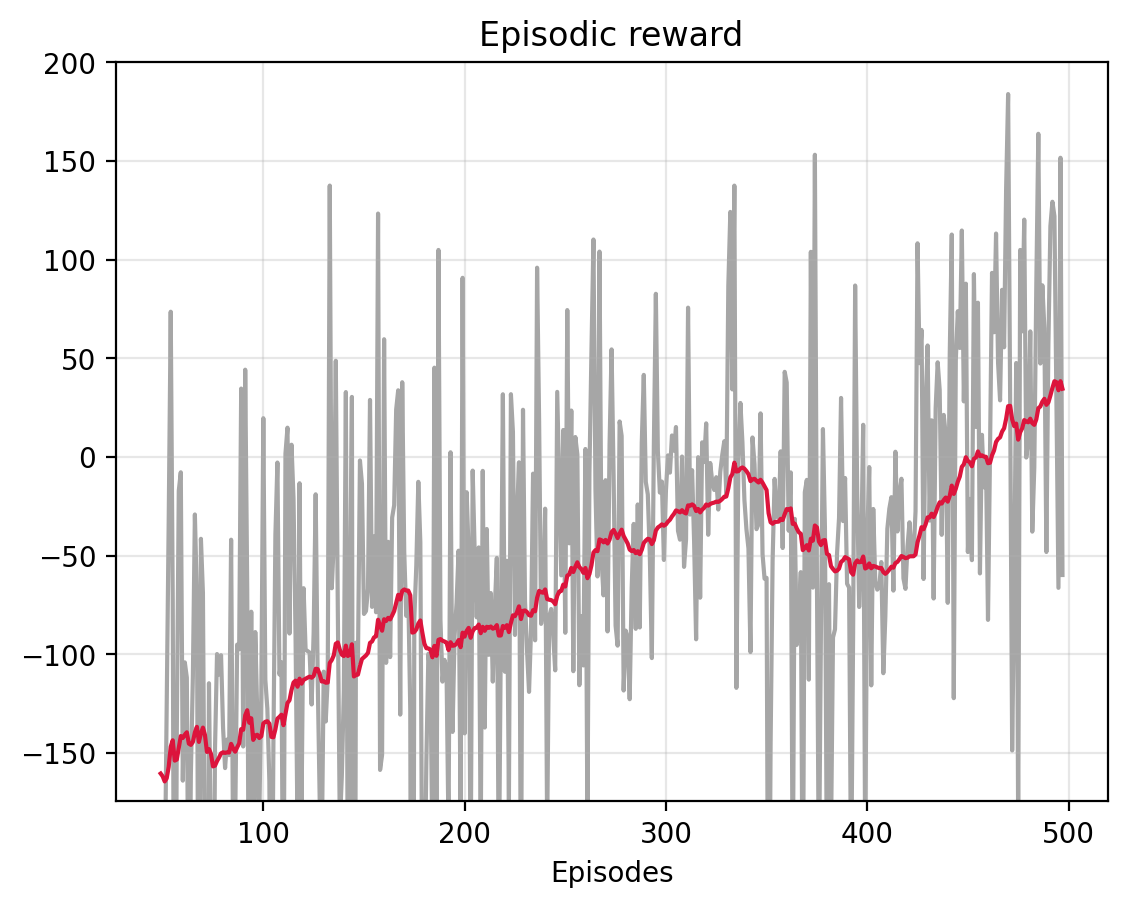

In [608]:
final_rewards.ewm(span=50, min_periods=50).mean().plot(c="crimson")
ymin, ymax = plt.ylim()
final_rewards.iloc[50:].plot(zorder=0, c="gray", alpha=0.7)
plt.ylim(ymin, 200)
# plt.axvline(x=n_static, c="black", linestyle="dashed")
plt.title("Episodic reward")
plt.xlabel("Episodes")
plt.grid(alpha=0.3)

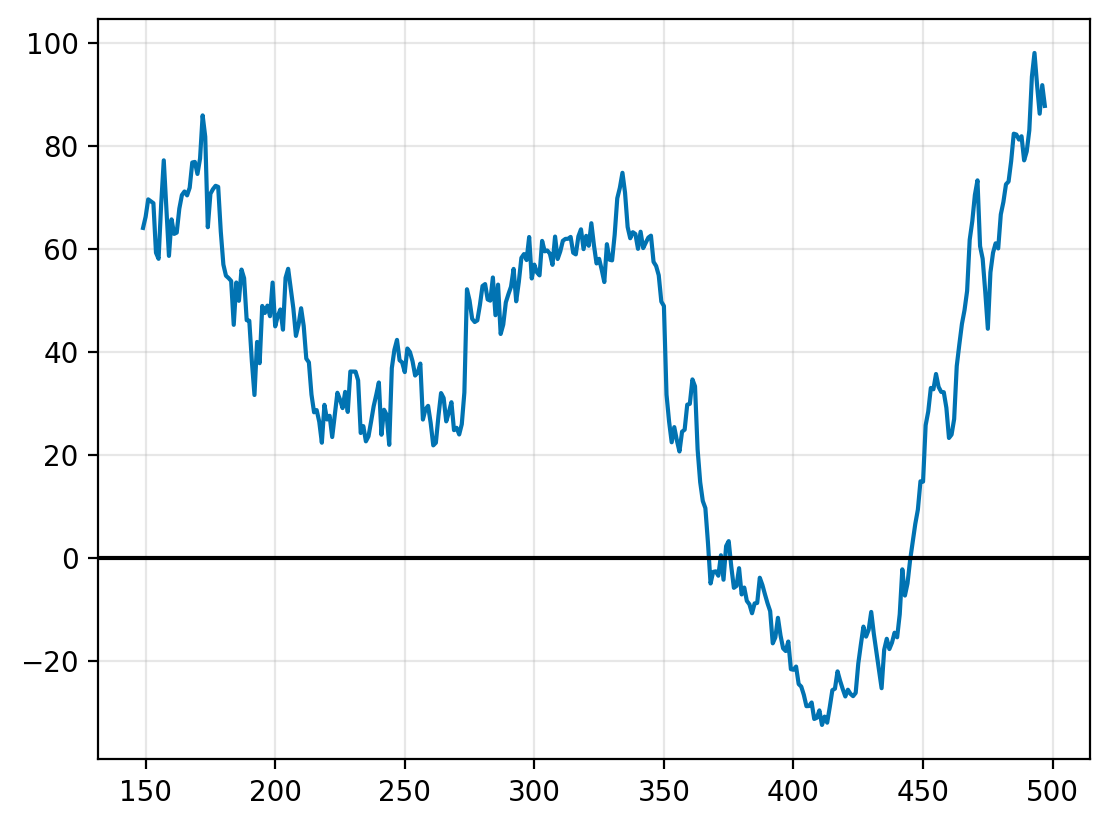

In [609]:
final_rewards.diff(100).ewm(span=50, min_periods=50).mean().plot()
# plt.axvline(x=n_static, c="black", linestyle="dashed")
plt.axhline(y=0.0, c="black")
plt.grid(alpha=0.3)

## Testing policy

In [610]:
n_steps = 1000
eps = 5e-4

observation, info = env.reset(seed=314)
action = eps_greedy_choice(M, observation, eps)

observations = []
rewards = []
actions_hist = []

episode_reward = 0.0
for t in range(n_steps):
    observation, reward, terminated, truncated, info = env.step(action)
    
    action = eps_greedy_choice(M, observation, eps)

    reset = terminated or truncated
    rewards.append(reward)
    actions_hist.append(action)
    observations.append(observation)
    
    if reset:
        observation, info = env.reset()
        # action = eps_greedy_choice(W, observation, eps)
        break

observations = np.array(observations)
rewards = np.array(rewards)
print(f"\n{rewards.sum()}")


215.07512407134243


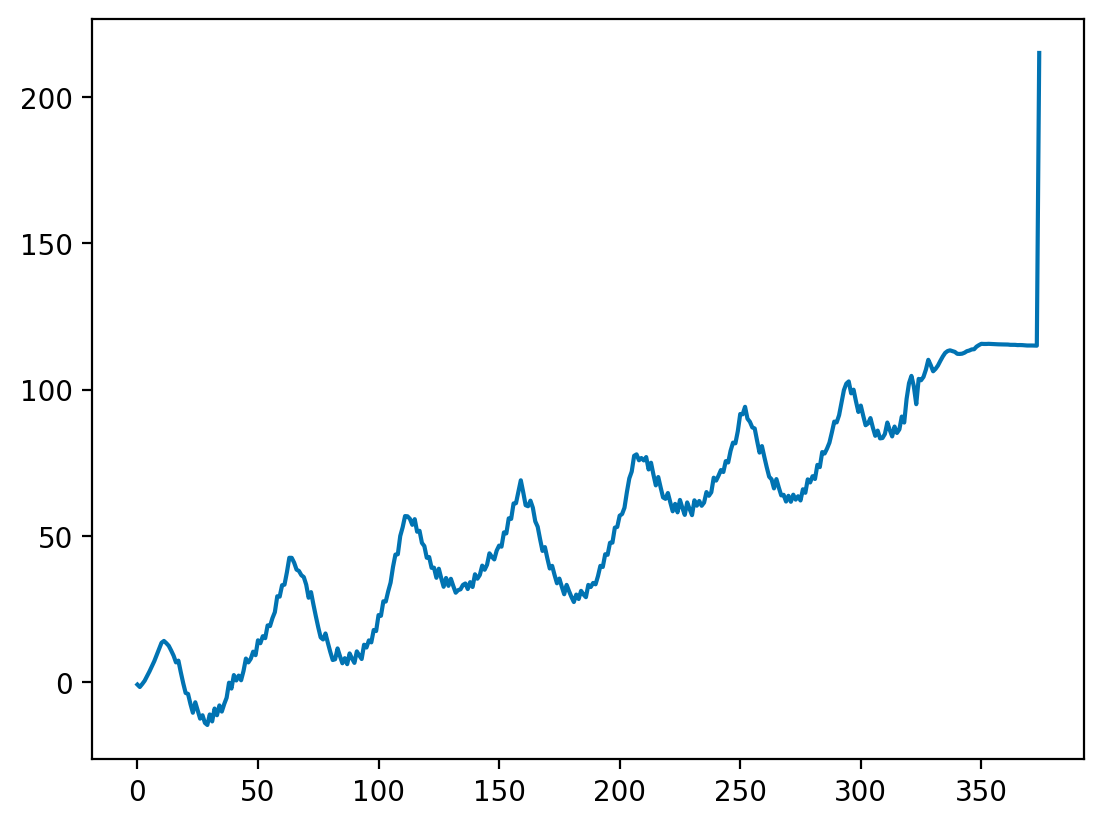

In [611]:
plt.plot(rewards.cumsum())

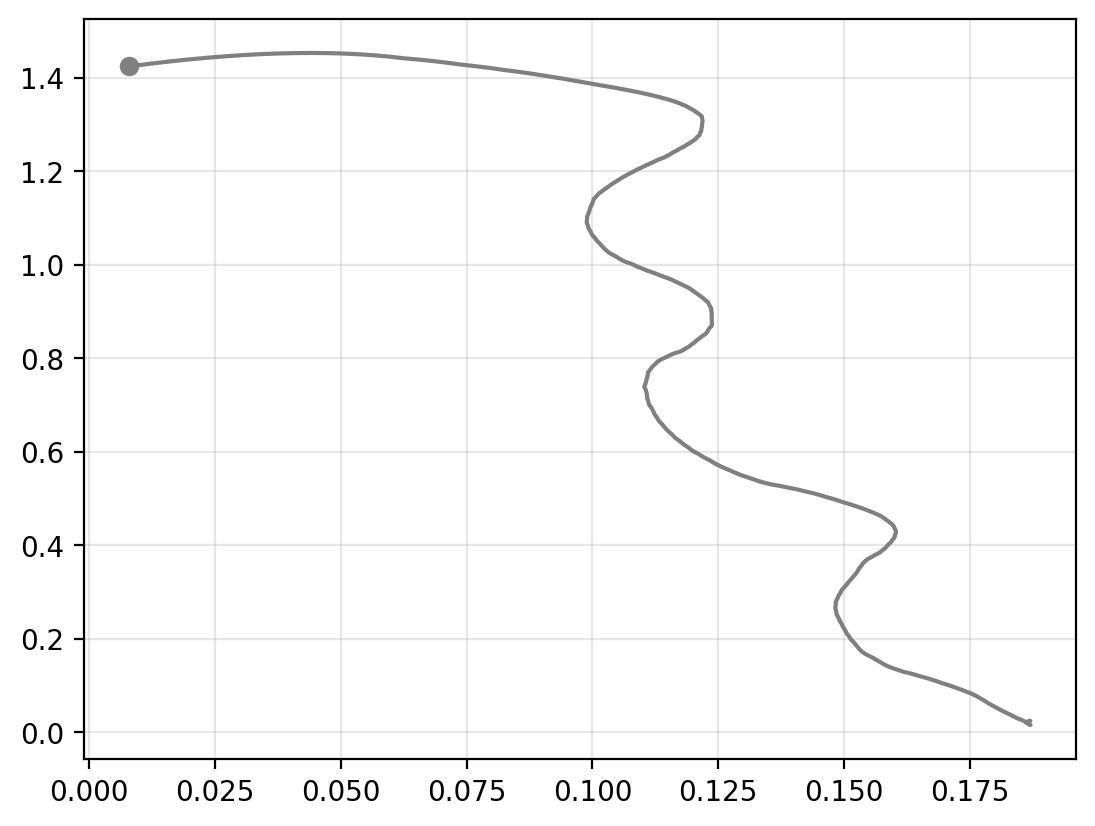

In [612]:
plt.plot(*observations[:, :2].T, c="gray")
plt.scatter(*observations[0, :2], c="gray")
plt.grid(alpha=0.3)

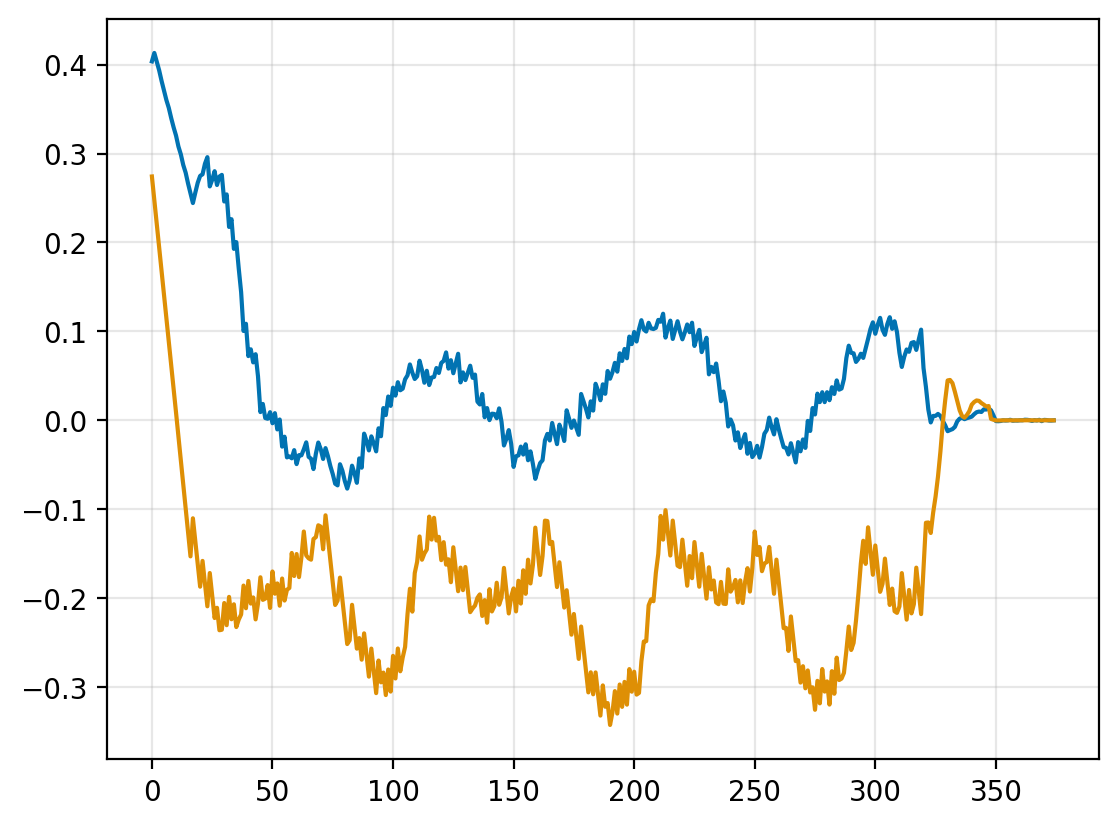

In [613]:
plt.plot(observations[:, 2:4])
plt.grid(alpha=0.3)

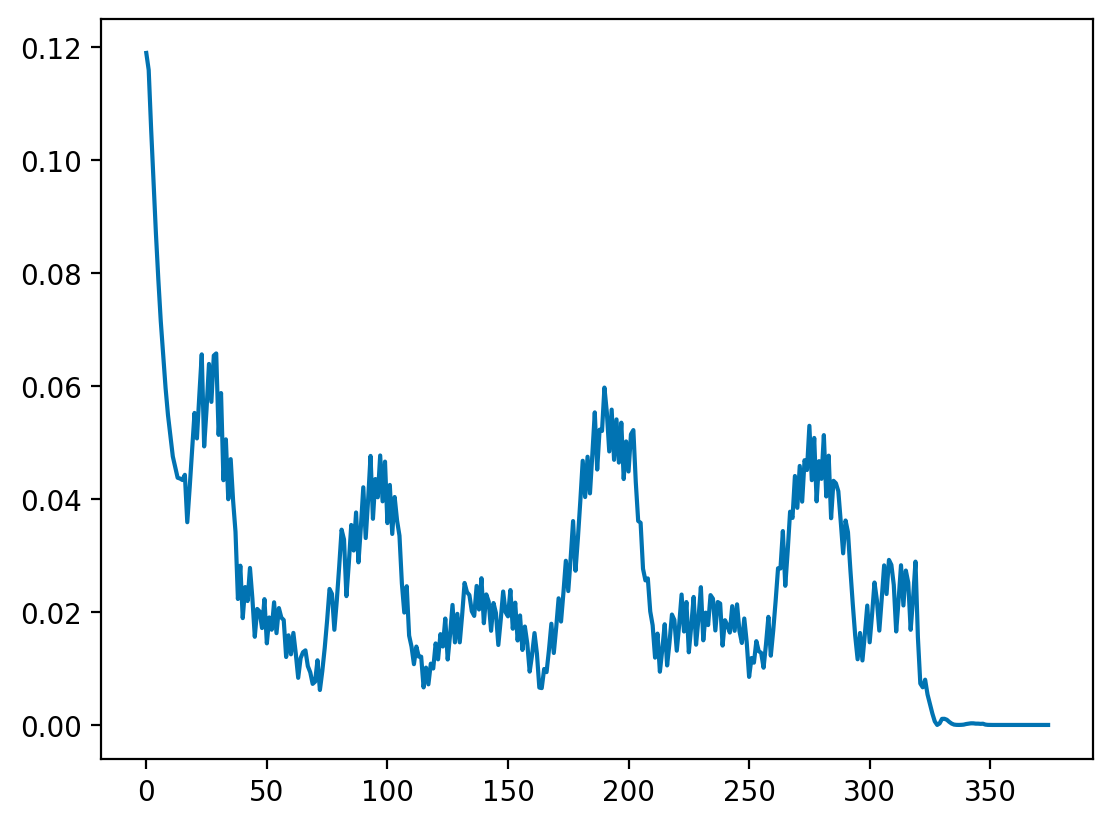

In [614]:
vel = np.power(observations[:, 2:4], 2).mean(axis=1)
plt.plot(vel)

In [653]:
observation, info = env.reset(seed=314)

observation[2] = 0.4
observation[3] = 0.1

elements = [
    "x-pos", "y-pos", "x-vel", "y-vel", "angle", "angular-vel", "contact-left", "contact-right"
]

for k, (o, e) in enumerate(zip(observation, elements)):
    print(k, e, o)



0 x-pos 0.0038757324
1 y-pos 1.4176669
2 x-vel 0.4
3 y-vel 0.1
4 angle -0.004484194
5 angular-vel -0.08891894
6 contact-left 0.0
7 contact-right 0.0


In [654]:
xspace = np.linspace(-1, 1, 500)
yspace = np.linspace(0, 2, 500)
Ogrid = np.stack(np.meshgrid(xspace, yspace))
Ogrid = np.einsum("mij->ijm", Ogrid)
Fgrid = np.zeros((500, 500))

In [655]:
for i in range(500):
    for j in range(500):
        sub_pos = Ogrid[i,j]
        observation[:2] = sub_pos
        res = eval_action_value(M, observation, actions)
        Fgrid[i,j] = res.argmax()

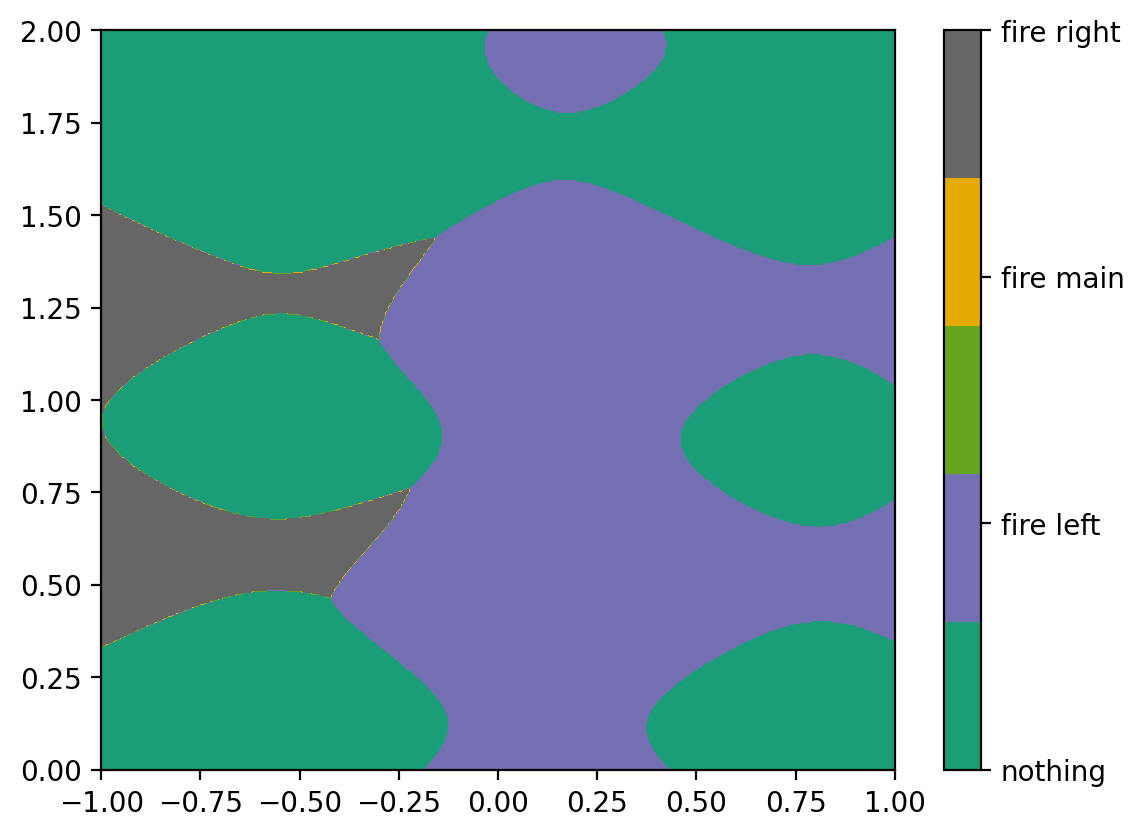

In [656]:
plt.contourf(xspace, yspace, Fgrid, cmap="Dark2", levels=4)
cax = plt.colorbar(ticks=actions)

labels = ["nothing", "fire left", "fire main", "fire right"]
cax.ax.set_yticklabels(labels);

## Multiple runs

In [620]:
colors = np.linspace(0, 1, len(checkpoint_episodes))
colors = plt.cm.viridis(colors)

-5463.551987068058
-286.413366838598
-340.68383976708276
-153.92002319447838
-196.2573845861806
-107.64960699141118


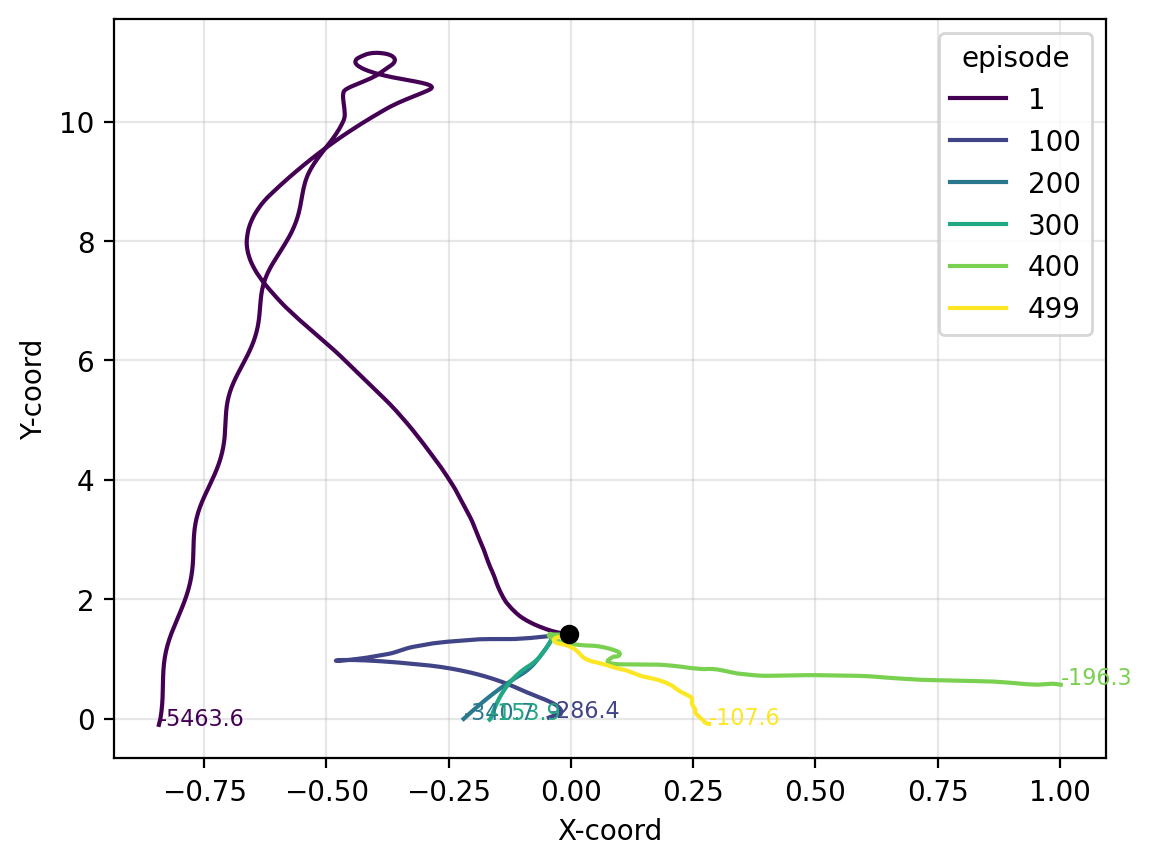

In [621]:
n_steps = 1000
eps = 1e-4
eps = 0.0 # Test greedy policy

for W, episode, color in zip(checkpoint_weights, checkpoint_episodes, colors):
    observation, info = env.reset(seed=3141)
    action = eps_greedy_choice(W, observation, eps)
    
    observations = []
    actions_hist = []
    
    episode_reward = 0.0
    for t in range(n_steps):
        observation, reward, terminated, truncated, info = env.step(action)
        
        action = eps_greedy_choice(W, observation, eps)
    
        reset = terminated or truncated
        actions_hist.append(action)
        observations.append(observation)
        
        episode_reward += reward
        if reset:
            observation, info = env.reset()
            # action = eps_greedy_choice(W, observation, eps)
            break
    
    observations = np.array(observations)

    plt.plot(*observations[:, :2].T, label=episode, c=color)
    
    last_x, last_y = observations[-1, :2]
    last_r = f"{episode_reward:0.1f}"
    plt.text(last_x, last_y, last_r, color=color, fontsize=8)
    print(episode_reward)

plt.scatter(*observations[0, :2], c="black", zorder=2)
plt.xlabel("X-coord")
plt.ylabel("Y-coord")
plt.legend(title="episode")
plt.grid(alpha=0.3)

In [622]:
checkpoint_weights.shape

(6, 4, 37)

In [623]:
np.save("weights.npy", M)